In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

from scipy.sparse import coo_matrix, hstack

import pymystem3
mystem = pymystem3.Mystem()

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import re

## Loading data

Нужно классифировать фамили:
- 0 если не фамилия
- 1 если фамилия
Классы несбалансированы нужно использовать roc_auc

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train = train.drop(index = train[train.Word.duplicated()].index, axis=1)

CountVectorizer поддерживает подсчет N-грам слов или последовательностей символов. Векторизатор строит словарь индексов признаков
Значение индекса слова в словаре связано с его частотой употребления во всем обучающем корпусе.
Будем использовать Наивный Байесовский классификатор и scikit-learn включает в себя несколько вариантов этого классификатора. Самый подходящий для подсчета слов — это его поли номинальный вариант.

Создадим конвеер для того, чтобы было продбирать гиперпараметры с помощью GridSearchCV, не забывая при этом разбивать на фолды. В качестве теста пробую Kmeans

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f540b79bf98>]],
      dtype=object)

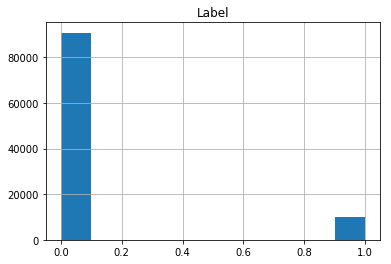

In [4]:
train.hist()

## Features extraction

In [18]:
consonants = list(u'йцкнгшщзхъфвпрлджчсмтьб'+u'йцкнгшщзхъфвпрлджчсмтьб'.upper())
vowels = list(u'уеёыаоэяию'+u'уеёыаоэяию'.upper())

def name_from_pymystem(word):
    try:
        return 1 if 'имя' in mystem.analyze(word)[0]['analysis'][0]['gr'].split(',') else 0
    except:
        return 0

def surn_from_pymystem(word):
    try:
        return 1 if 'фам' in mystem.analyze(word)[0]['analysis'][0]['gr'].split(',') else 0
    except:
        return 0
    
def up_cases(word):
    return sum(1 for c in word if c.isupper())

def low_cases(word):
    return sum(1 for c in word if c.isupper())

def vow(word):
    return sum(1 for c in word if c in vowels)

def con(word):
    return sum(1 for c in word if c in consonants)

def spec(word):
    return sum(1 for c in word if c not in consonants or c not in vowels)

def len_eq(word):
    if len(word) == con(word) or len(word) == vow(word) or len(word) < 4 or len(word) > 13:
        return 1
    else:
        return 0

def Make_x(X_train):
    X_train['name_from_pymystem'] = X_train['Word'].apply(name_from_pymystem)
    X_train['surn_from_pymystem'] = X_train['Word'].apply(surn_from_pymystem)
    X_train['up_cases'] = X_train['Word'].apply(up_cases)
    X_train['low_cases'] = X_train['Word'].apply(low_cases)
    X_train['con'] = X_train['Word'].apply(con)
    X_train['vow'] = X_train['Word'].apply(vow)
    X_train['len'] = X_train['Word'].apply(lambda word: len(list(word)))
    
    
    return X_train[['name_from_pymystem','surn_from_pymystem',
                    'up_cases', 'low_cases',
                    'con', 'vow','len']].as_matrix()

In [19]:
train = train.drop(index = train[((train['Word'].apply(len_eq) == 1) | (train['Word'].apply(spec) <= 1) )
                                 & (train['Label'] == 1)].index, axis=1)

## Finding param

In [20]:
def Testing_grid_reg(X_train, Y_train, c=[10.0 ** i for i in range(-3, 5)]):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cc = CountVectorizer(encoding = 'unicode',
                         lowercase = False,
                         analyzer = 'char', 
                         ngram_range = (2,7), 
                         min_df = 3, 
                         max_df = 14)
    X_train_cc = cc.fit_transform(X_train['Word'].as_matrix())
    
    X_train = hstack((X_train_cc, Make_x(X_train)))
    
    clf = LogisticRegression(class_weight = 'balanced', solver = 'sag', n_jobs=1)
    
    grid=  {'C': c,
            'penalty' : ['l2'],
            'max_iter' : [10000]
           }
    
    start_time = datetime.datetime.now()
    gs = GridSearchCV(clf, scoring='roc_auc', 
                      param_grid=grid, cv=cv, 
                      return_train_score=True, n_jobs=-1, verbose = True)
    gs.fit(X_train,Y_train)
    
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    print (max(gs.cv_results_['mean_test_score']))
    
    return gs.best_params_

In [33]:
def Testing_grid_lgb(X_train, Y_train):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cc = CountVectorizer(encoding = 'unicode',
                         lowercase = False,
                         analyzer = 'char', 
                         ngram_range = (2,7), 
                         min_df = 3, 
                         max_df = 14,
                         dtype= np.float32)
    X_train_cc = cc.fit_transform(X_train['Word'].as_matrix())
    
    X_train = hstack((X_train_cc, Make_x(X_train)))
    
    # Create parameters to search
    gridParams = {
        'n_estimators': [90],
        'learning_rate': [0.7],
        'num_leaves': [100],
        'boosting_type' : ['dart'],
        'objective' : ['binary'],
        'colsample_bytree' : [0.8],
        'reg_alpha' : [0.9],
        'reg_lambda' : [0.1],
        'subsample_freq': [0.5, 1],
        'min_split_gain': [0.01, 0.05], 
        'min_child_weight': [1, 5],
        'scale_pos_weight': [0.5]
    }
    
    clf = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                             objective = 'binary', 
                             class_weight = 'balanced',
                             n_jobs = 1, # Updated from 'nthread' 
                             silent = False,
                             max_depth = -1,
                             max_bin = 512,
                             subsample_for_bin = 800,
                             bagging_freq = 4
                            )
    
    
    start_time = datetime.datetime.now()
    gs = GridSearchCV(clf, scoring='roc_auc',
                      param_grid=gridParams, cv=cv, 
                      return_train_score=True, n_jobs=-1, verbose = True,
                      refit=True)
    gs.fit(X_train,Y_train, eval_metric=['roc_auc', 'f1'])
    
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    print (max(gs.cv_results_['mean_test_score']))
    
    return gs.best_params_

In [34]:
p = Testing_grid_lgb(train, train['Label'].as_matrix())
print (p)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   54.0s finished


Time elapsed: 0:00:56.189551
0.9056704446277791
{'boosting_type': 'dart', 'colsample_bytree': 0.8, 'learning_rate': 0.7, 'min_child_weight': 1, 'min_split_gain': 0.05, 'n_estimators': 90, 'num_leaves': 100, 'objective': 'binary', 'reg_alpha': 0.9, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5, 'subsample_freq': 0.5}


## Retrain our model

In [40]:
def vec():
    cc = CountVectorizer(encoding = 'unicode',
                         lowercase = False,
                         analyzer = 'char', 
                         ngram_range = (2,8), 
                         min_df = 3, 
                         max_df = 14,
                         dtype= np.float32)
    cc = cc.fit(train['Word'].as_matrix())
    
    X_test_cc, X_train_cc = cc.transform(test['Word'].as_matrix()), cc.transform(train['Word'].as_matrix())
        
    X_train = hstack((X_train_cc, Make_x(train)))
    X_test = hstack((X_test_cc, Make_x(test)))
    
    return X_train, train['Label'].as_matrix(), X_test

def Predict_reg(p):
    
    X_train, y_train, X_test = vec()
    clf = LogisticRegression(class_weight = 'balanced', 
                             solver = 'sag', n_jobs=1,
                             C = p['C'],
                             penalty = p['penalty'],
                             max_iter = p['max_iter'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    return y_pred

def Predict_lgb(p):
    X_train, y_train, X_test = vec()
    
    clf = lgb.LGBMClassifier(boosting_type= 'gbdt', objective = 'binary', 
                             class_weight = 'balanced',
                             n_jobs = 1, # Updated from 'nthread' 
                             silent = False,
                             max_depth = -1,
                             max_bin = 512,
                             subsample_for_bin = 250,
                             bagging_freq = 4,    
                             n_estimators = p['n_estimators'],
                             learning_rate = p['learning_rate'],
                             num_leaves = p['num_leaves'],
                             colsample_bytree = p['colsample_bytree'],
                             reg_alpha = p['reg_alpha'],
                             reg_lambda = p['reg_lambda'],
                             subsample_freq = p['subsample_freq'],
                             min_split_gain = p['min_split_gain'], 
                             min_child_weight = p['min_child_weight']
                            )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    
    return y_pred


## Labling trest data

In [41]:
y_pred = Predict_lgb(p)
sample = pd.read_csv('sample_submission.csv')
sample['Prediction'] = y_pred
sample.to_csv('res.csv',index=False)

/home/denis/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
